In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
from manifold_encoder_decoder import s1_direct_product_decoder, geometry_util

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [45]:
data_path = "/home/trevor/Downloads/hd_data/analyses/2019_03_kernel_rates/100ms_sigma/Mouse28-140313.p"
with open(data_path, 'rb') as f:
    data = pickle.load(f, encoding='latin1')


In [46]:
cell_labels = data["cells"]
rate_data = list(data["Wake"].values())[0]
rates = np.transpose(np.array(list(rate_data['rates'].values())))
angles = rate_data['angles']


In [47]:
normed_rates = rates/np.mean(np.abs(rates))


In [48]:
decoder_hidden_size = 2500
encoder_hidden_size = decoder_hidden_size
decoder_n_hidden = 2
encoder_n_hidden = decoder_n_hidden

In [49]:
import importlib
importlib.reload(s1_direct_product_decoder)
encoder, decoder = s1_direct_product_decoder.train(data=normed_rates, manifold_dim=1, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1, batch_size=50, encoder_hidden_dim=encoder_hidden_size, encoder_n_hidden=encoder_n_hidden, decoder_hidden_dim=decoder_hidden_size, decoder_n_hidden=decoder_n_hidden, layer_nonlin=torch.nn.ReLU)


iteration: 0, decoding loss: 4.731356620788574, distance cost: 0.0006242747767828405, order reduction: 0.004455566871911287
iteration: 1, decoding loss: 2.5395028591156006, distance cost: 0.014316625893115997, order reduction: 0.002750696148723364
iteration: 3, decoding loss: 2.157633066177368, distance cost: 0.07549665868282318, order reduction: 0.002213882515206933
iteration: 4, decoding loss: 1.9334872961044312, distance cost: 0.06905967742204666, order reduction: 0.0028575710020959377
iteration: 5, decoding loss: 1.9317010641098022, distance cost: 0.05336948484182358, order reduction: 0.0024623097851872444
iteration: 7, decoding loss: 1.9293099641799927, distance cost: 0.04169623926281929, order reduction: 0.003639169503003359
iteration: 8, decoding loss: 1.9036359786987305, distance cost: 0.04464451223611832, order reduction: 0.0015510465018451214
iteration: 9, decoding loss: 1.799387812614441, distance cost: 0.04186985641717911, order reduction: 0.001914770808070898
iteration: 10

In [50]:
n_projections = 6
embed_dim = np.shape(normed_rates)[1]
random_projections = np.random.normal(0, 1, (n_projections, 2, embed_dim))
col_norm = np.einsum("ijk, ijk -> ik", random_projections, random_projections)
normed_proj = np.einsum("ijk, ik -> ijk", random_projections, 1/np.sqrt(col_norm))
projected_data = np.einsum("bk, ijk -> bij", normed_rates, normed_proj)

In [51]:
test_angles = np.linspace(start=0, stop=2 * np.pi, num=1000)
test_points = np.expand_dims(geometry_util.angles_to_ring(test_angles), -2)
with torch.no_grad():
    test_embedding = encoder(torch.tensor(test_points, dtype=torch.get_default_dtype()).to(device))
test_embedding = test_embedding.cpu().numpy()
projected_test_embedding = np.einsum("bk, ijk -> bij", test_embedding, normed_proj)


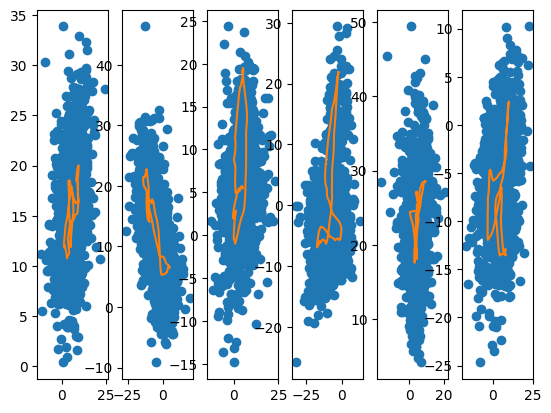

In [52]:
data_plot_density = 50
fig, axs = plt.subplots(ncols=n_projections)
for i in range(n_projections):
    axs[i].scatter(projected_data[::data_plot_density, i, 0], projected_data[::data_plot_density, i, 1], color="C0")
    axs[i].plot(projected_test_embedding[:, i, 0], projected_test_embedding[:, i, 1], color="C1")


In [53]:
with torch.no_grad():
    decoded_points, decoded_angles = decoder(torch.tensor(normed_rates, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()


In [54]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[1])

def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


In [55]:
not_nan_angle_idx = np.argwhere(np.logical_not(np.isnan(angles)))
not_nan_angles = angles[not_nan_angle_idx]
not_nan_preds = predicted_phases[not_nan_angle_idx]

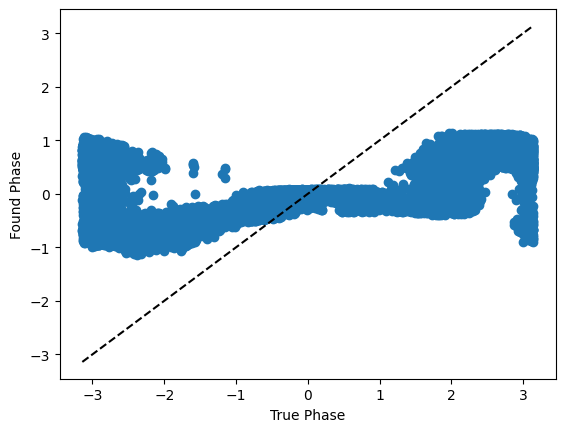

In [56]:
fig, axs = plt.subplots()
refd_pred, refd_data = compare_to_ground_truth(not_nan_preds, not_nan_angles, axs)
